In [1]:
import numpy as np 
import tensorflow as tf 

from IPython.display import clear_output
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image


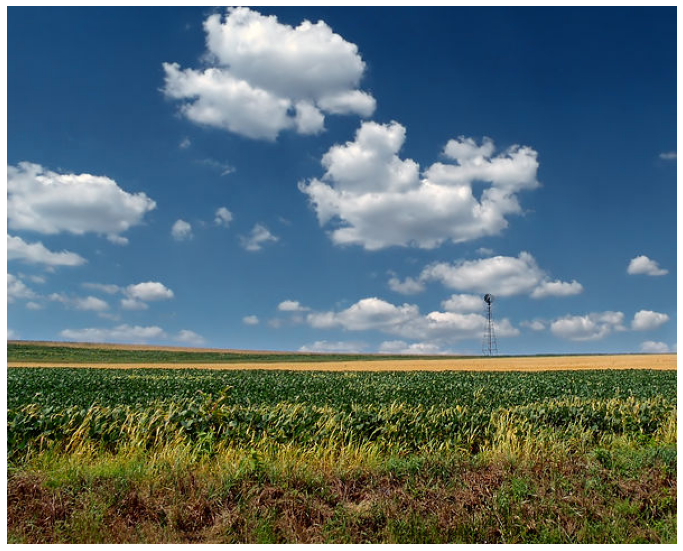

In [3]:
# Download an image and read it into a numpy array
def download(ur):
    name=url.split('/')[-1]
    image_path = tf.keras.utils.get_file(name, origin=url)
    img = image.load_img(image_path)

    return image.img_to_array(img)

# Scale pixels to between -1.0 and 1.0
def preprocess(img):
    return (img / 127.5) - 1

# Undo the preprocessing above
def deprocess(img):
    img = img.copy()
    img /= 2.
    img += 0.5
    img *= 255.

    return np.clip(img, 0, 255).astype(np.uint8)

# Display an image
def show(img):
    plt.figure(figsize=(12, 12))
    plt.grid(False)
    plt.axis('off')
    plt.imshow(img)

url = 'https://storage.googleapis.com/applied-dl/clouds.jpg'
img = preprocess(download(url))
show(deprocess(img))

In [4]:
inception_v3 = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False)

87916544/87910968 [==============================] - 204s 2us/step


In [5]:
# We'll maximize the activations of these layers
names = ['mixed2', 'mixed3', 'mixed4', 'mixed5']
layers = [inception_v3.get_layer(name).output for name in names]

# Create our feature extraction model
feature_extraction_model = tf.keras.Model(inputs=inception_v3.input, outputs=layers)

In [6]:
def forward(img):
    # Create a batch
    img_batch = tf.expand_dims(img, axis=0)

    # Forward the image through Inception, extract activations
    # for the layers we selected above
    return feature_extraction_model(img_batch)

In [8]:
def calc_loss(layer_activations):
    total_loss = 0

    for act in layer_activations:
        loss = tf.math.reduce_mean(act)

        loss /= np.prod(act.shape)
        total_loss += loss

    return total_loss

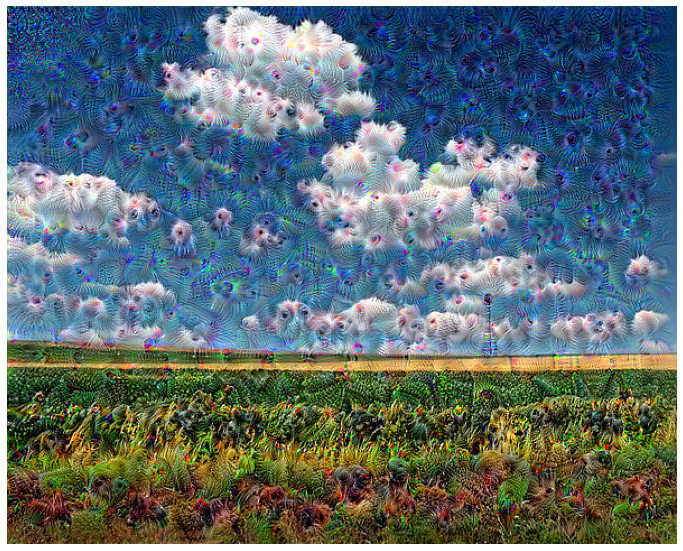

In [9]:
# conver our image into a variable for training
img = tf.Variable(img)

# Run a few iterations of gradient ascent
steps = 400

for step in range(steps):
    with tf.GradientTape() as tape:
        activations = forward(img)
        loss = calc_loss(activations)

    gradients = tape.gradient(loss, img)

    # normalize the gradients
    gradients /= gradients.numpy().std() + 1e-8

    img.assign_add(gradients)

    if step % 50 == 0:
        clear_output()
        print("Step {:3d} Loss {:1.5f}".format(step, loss))
        show(deprocess(img.numpy()))
        plt.show()

clear_output()
show(deprocess(img.numpy()))
